# Quantopian Research Basics
*This notebook can only be run on Quantopian Research* - https://www.quantopian.com/research

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels import regression
import statsmodels.api as sm

from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import SimpleMovingAverage, AverageDollarVolume
from quantopian.pipeline.filters import Q1500US
from quantopian.research import run_pipeline
from quantopian.research.experimental import history, continuous_future

import pyfolio as pf
import empyrical

In [5]:
mcd = get_pricing(symbols='MCD', start_date='2005-01-01', end_date='2017-01-01', frequency='daily')

In [10]:
mcd.head(1)

,open_price,high,low,close_price,volume,price
2005-01-03 00:00:00+00:00,22.11,22.55,22.068,22.271,4324900.0,22.271


In [7]:
mcd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3021 entries, 2005-01-03 to 2016-12-30
Freq: C
Data columns (total 6 columns):
open_price     3021 non-null float64
high           3021 non-null float64
low            3021 non-null float64
close_price    3021 non-null float64
volume         3021 non-null float64
price          3021 non-null float64
dtypes: float64(6)
memory usage: 165.2 KB


In [11]:
mcd_eq_info = symbols('MCD')
mcd_eq_info.to_dict()

{'asset_name': u'MCDONALDS CORP',
 'auto_close_date': Timestamp('2019-10-31 00:00:00+0000', tz='UTC'),
 'end_date': Timestamp('2019-10-28 00:00:00+0000', tz='UTC'),
 'exchange': u'NYSE',
 'exchange_full': u'NEW YORK STOCK EXCHANGE',
 'exchange_info': ExchangeInfo(u'NEW YORK STOCK EXCHANGE', u'NYSE', u'US'),
 'first_traded': None,
 'multiplier': 1.0,
 'sid': 4707,
 'start_date': Timestamp('2002-01-01 00:00:00+0000', tz='UTC'),
 'symbol': u'MCD',
 'tick_size': 0.01}

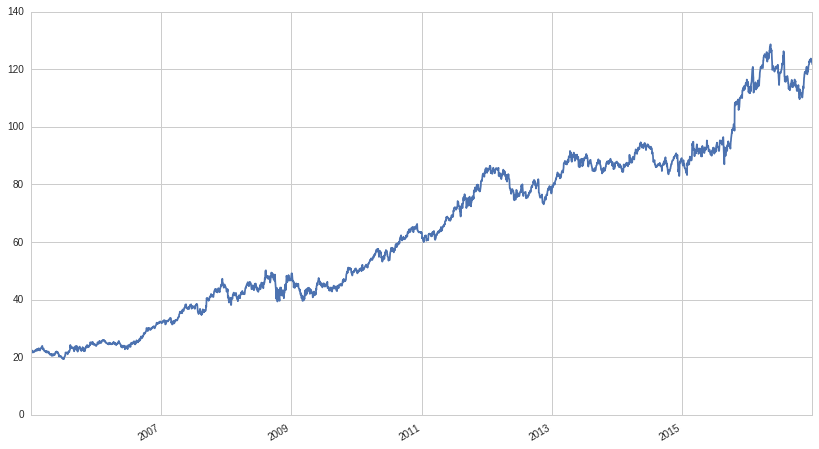

In [9]:
mcd['close_price'].plot();

## Pairs Trading Simple

In [2]:
united = get_pricing(symbols='UAL', start_date='2015-01-01', end_date='2017-01-01')
american = get_pricing(symbols='AAL', start_date='2015-01-01', end_date='2017-01-01')

High Correlation between 2 airlines stocks


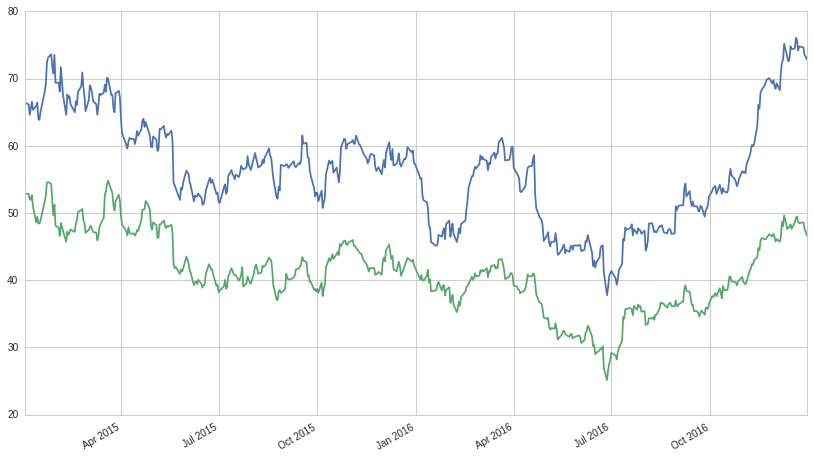

In [5]:
print('High Correlation between 2 airlines stocks')
united['close_price'].plot(label='United');
american['close_price'].plot(label='American');

In [7]:
np.corrcoef(american['close_price'], united['close_price'])

array([[ 1.        ,  0.92333958],
       [ 0.92333958,  1.        ]])

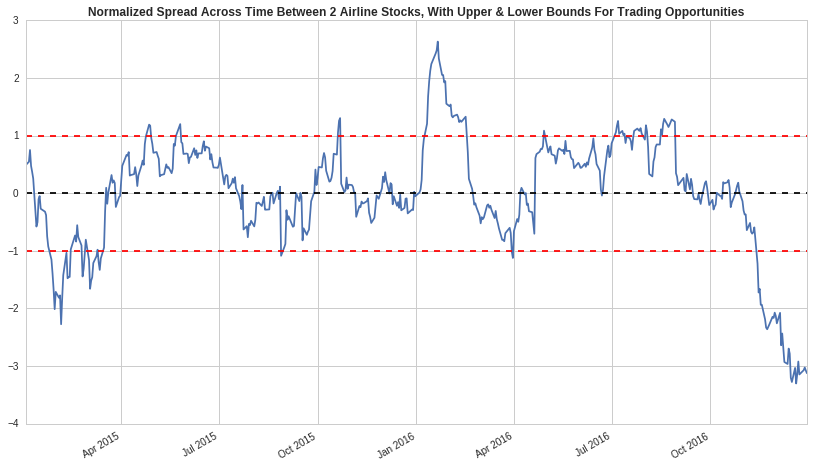

In [20]:
# Normalize spreads
def zscore(distribution):
    return (distribution - distribution.mean()) / distribution.std()

spread = american['close_price'] - united['close_price']
zscore(spread).plot(label='Norm Spread')
plt.axhline(zscore(spread).mean(), label='mean', c='black', linestyle='--')
plt.axhline(1, label='upper', c='r', linestyle='--')
plt.axhline(-1, label='lower', c='r', linestyle='--')
plt.title(
    'Normalized Spread Across Time Between 2 Airline Stocks, With Upper & Lower Bounds For Trading Opportunities',
    fontweight='bold'
);

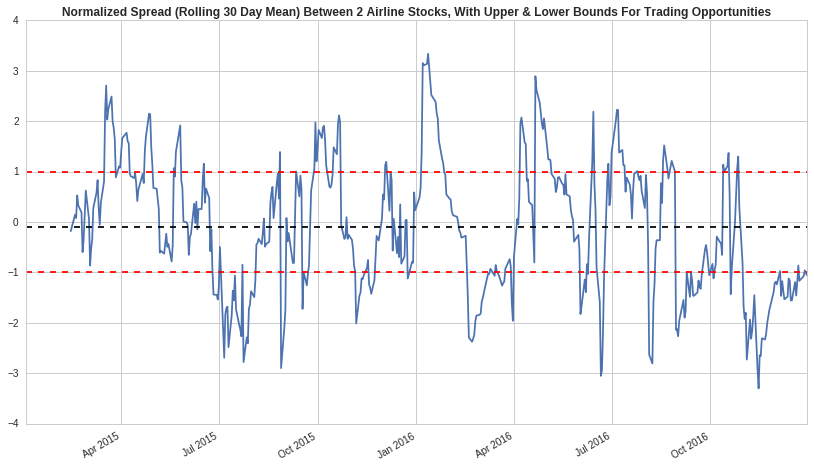

In [21]:
spread_ma1 = spread.rolling(1).mean()
spread_ma30 = spread.rolling(30).mean()
spread_std30 = spread.rolling(30).std()

spread_z = (spread_ma1 - spread_ma30) / (spread_std30)

spread_z.plot(label='Norm Spread Rolling 30 Day')
plt.axhline(spread_z.mean(), label='mean', c='black', linestyle='--')
plt.axhline(1, label='upper', c='r', linestyle='--')
plt.axhline(-1, label='lower', c='r', linestyle='--')
plt.title(
    'Normalized Spread (Rolling 30 Day Mean) Between 2 Airline Stocks, With Upper & Lower Bounds For Trading Opportunities',
    fontweight='bold'
);

## Pipeline

* Factors are usually numerical indicators (e.g. SMA, MACD, etc)
* Filters are passed into screens to filter only relevant indexes (i.e. date - stock combo)
* Masks are similar to filters, but are applied anywhere, even before factors
* Classifiers return various classes of the index (i.e. date - stock combo)

Flow: *get factors/classes **->** build filter/mask **->** get more factors/classes with filter/mask **->** build filter/mask **->** instantiate pipeline object with final filter as screen, and other desired columns to show*

In [102]:
def make_pipeline():
    
    # PREPARE MASKS
    ## CATEGORICAL MASKS
    universe_filter = Q1500US()
    sector_filter = morningstar.asset_classification.morningstar_sector_code.latest.eq(309)  # 309 is energy sector
    # exchange_filter = morningstar.share_class_reference.exchange_id.latest.eq('NYS')
    base_filter = (
        universe_filter
        & sector_filter
        # & exchange_filter
    )
    ## NUMERIC/FACTOR MASKS
    volume_ma30 = AverageDollarVolume(window_length=30)
    volume_ma30_filter = volume_ma30.percentile_between(95, 100)
    # mkt_cap_filter = morningstar.Fundamentals.market_cap.latest < 100000000
    base_filter = (
        base_filter
        & volume_ma30_filter
        # & mkt_cap_filter
    )
    close_ma30 = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=30, mask=base_filter)
    close_ma10 = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=10, mask=base_filter)
    pct_diff = (close_ma10 - close_ma30) / close_ma30
    shorts_filter = pct_diff < 0
    longs_filter = pct_diff > 0
    base_filter = (
        base_filter
        & (shorts_filter | longs_filter)
    )
    
    return Pipeline(
        columns={
            'Close MA30': close_ma30, 
            'Pct Diff': pct_diff,
            'Longs': longs_filter,
            'Shorts': shorts_filter
        },
        screen=base_filter
    )

In [103]:
# result is a dataframe with no columns, only multi-index on date -> equities
result = run_pipeline(
    pipeline=make_pipeline(), 
    start_date='2015-05-05', 
    end_date='2015-05-05'
)

In [108]:
result.head()

Close MA30 Longs  Pct Diff  \
2015-05-05 00:00:00+00:00 Equity(216 [HES])    73.181833  True  0.036528   
                          Equity(448 [APA])    65.482446  True  0.035926   
                          Equity(455 [APC])    89.041333  True  0.049153   
                          Equity(858 [BHI])    66.071300  True  0.033807   
                          Equity(1746 [COG])   31.507567  True  0.058078   

                                             Shorts  
2015-05-05 00:00:00+00:00 Equity(216 [HES])   False  
                          Equity(448 [APA])   False  
                          Equity(455 [APC])   False  
                          Equity(858 [BHI])   False  
                          Equity(1746 [COG])  False

In [109]:
result.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 38 entries, (2015-05-05 00:00:00+00:00, Equity(216 [HES])) to (2015-05-05 00:00:00+00:00, Equity(42788 [PSX]))
Data columns (total 4 columns):
Close MA30    38 non-null float64
Longs         38 non-null bool
Pct Diff      38 non-null float64
Shorts        38 non-null bool
dtypes: bool(2), float64(2)
memory usage: 988.0+ bytes


## Leverage

**Need to run backtest in Quantopian algorithm first, before importing the backtest hashcode here for further analysis*

In [120]:
# backtest hashcode is generated when running a quantopian algorithm backtest
backtest_low_leverage = get_backtest('5db69510cabced4a4ab1647d')
backtest_high_leverage = get_backtest('5db696488fa85a4bf877e6d1')

100% Time:  0:00:01|##########################################################|
100% Time:  0:00:00|##########################################################|


In [116]:
backtest_low_leverage.recorded_vars.head()

,amzn_close,exposure,ibm_close,leverage
2016-08-04 00:00:00+00:00,760.960,0.001829,161.41,1.006561
2016-08-05 00:00:00+00:00,765.890,-0.003748,163.45,1.006744
2016-08-08 00:00:00+00:00,766.360,0.002860,162.05,0.998715
2016-08-09 00:00:00+00:00,767.705,-0.002599,161.75,0.999688
2016-08-10 00:00:00+00:00,768.480,0.000702,162.02,0.998044


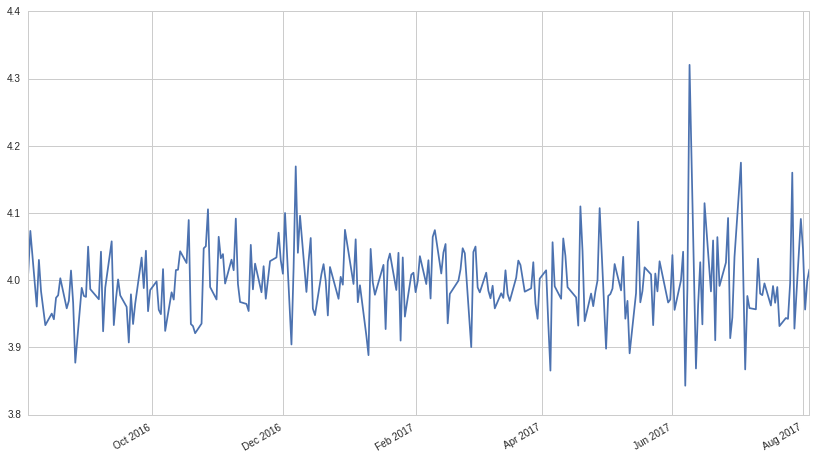

In [124]:
# backtest_low_leverage.recorded_vars['leverage'].plot();
backtest_high_leverage.recorded_vars['leverage'].plot();

## Hedging

Reduce portfolio's $\beta$

In [137]:
start_dt = '2016-01-01'
end_dt = '2017-01-01'

aapl = get_pricing('AAPL', fields='price', start_date=start_dt, end_date=end_dt)
spy = get_pricing('SPY', fields='price', start_date=start_dt, end_date=end_dt)

In [148]:
aapl_ret = aapl.pct_change(1)[1:]
spy_ret = spy.pct_change(1)[1:]

In [153]:
def get_alpha_beta(benchmark_ret, stock_ret):
    benchmark = sm.add_constant(benchmark_ret)
    model = regression.linear_model.OLS(stock_ret, benchmark).fit()
    alpha, beta = model.params
    return alpha, beta

alpha, beta = get_alpha_beta(spy_ret, aapl_ret)

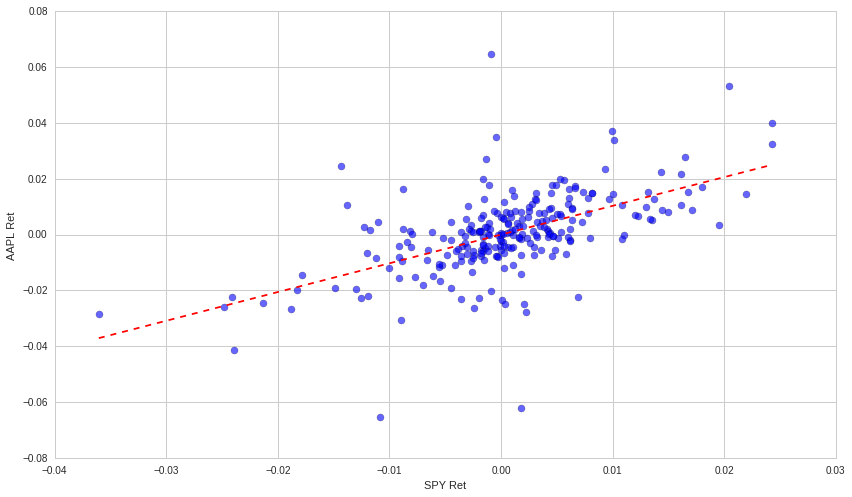

In [154]:
min_spy_ret = spy_ret.values.min()
max_spy_ret = spy_ret.values.max()

spy_ret_x = np.linspace(min_spy_ret, max_spy_ret, 100)
spy_ret_y = beta * spy_ret_x + alpha

plt.plot(spy_ret_x, spy_ret_y, 'r--')
plt.scatter(spy_ret, aapl_ret, alpha=0.6, s=50)
plt.xlabel('SPY Ret')
plt.ylabel('AAPL Ret');

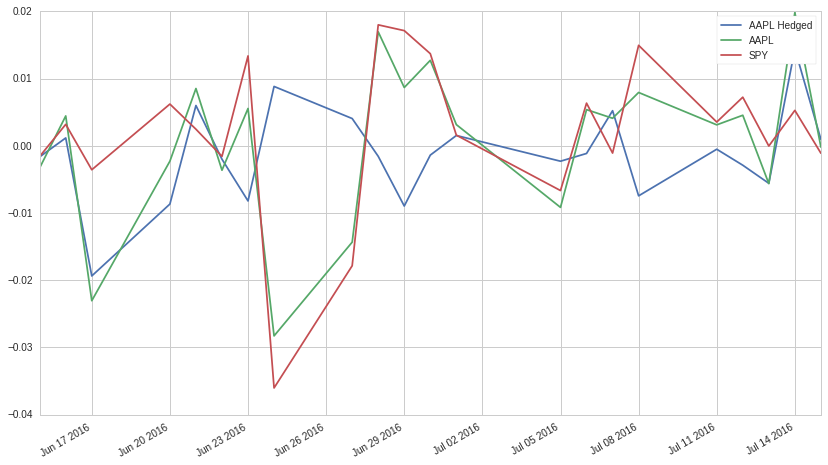

In [165]:
# beta used here is usually previous year's beta
# hedged is achieved by shorting SPY
hedged = -1 * (beta * spy_ret) + aapl_ret  # cancel out effects of beta with main aapl portfolio

hedged['2016-06-15':'2016-07-15'].plot(label='AAPL Hedged')
aapl_ret['2016-06-15':'2016-07-15'].plot(label='AAPL')
spy_ret['2016-06-15':'2016-07-15'].plot(label='SPY')
plt.legend();

In [163]:
alpha_hedged, beta_hedged = get_alpha_beta(spy_ret, hedged.values)
print('Hedged beta is close to zero: {}'.format(beta_hedged))
print('Lower volatility (hedged: {} vs aapl: {}) but lower returns as well (hedged: {} vs aapl: {})'
      .format(hedged.values.std(), aapl.values.std(), hedged.values.mean(), aapl.values.mean())
     )

Hedged beta is close to zero: 1.36609473733e-16
Lower volatility (hedged: 0.0120413890649 vs aapl: 8.01807804095) but lower returns as well (hedged: 1.679902481e-05 vs aapl: 103.595230159)


## Pyfolio Portfolio Analysis

In [173]:
bt = get_backtest('5db69510cabced4a4ab1647d')
bt_ret = bt.daily_performance['returns']
bt_positions = bt.pyfolio_positions
bt_transactions = bt.pyfolio_transactions

bm = get_backtest('5db6ab8206f8074bfeed6448')
bm_ret = bm.daily_performance['returns']
bm_positions = bm.pyfolio_positions
bm_transactions = bm.pyfolio_transactions

print('Portfolio SR = {}'.format(empyrical.sharpe_ratio(bt_ret)))
print('Benchmark SR= {}'.format(empyrical.sharpe_ratio(bm_ret)))
print('Portfolio Beta = {}'.format(empyrical.beta(bt_ret, bm_ret)))

100% Time:  0:00:00|##########################################################|
100% Time:  0:00:00|##########################################################|


Portfolio SR = 1.69212021737
Benchmark SR= 1.94926413476
Portfolio Beta = 0.141799968503


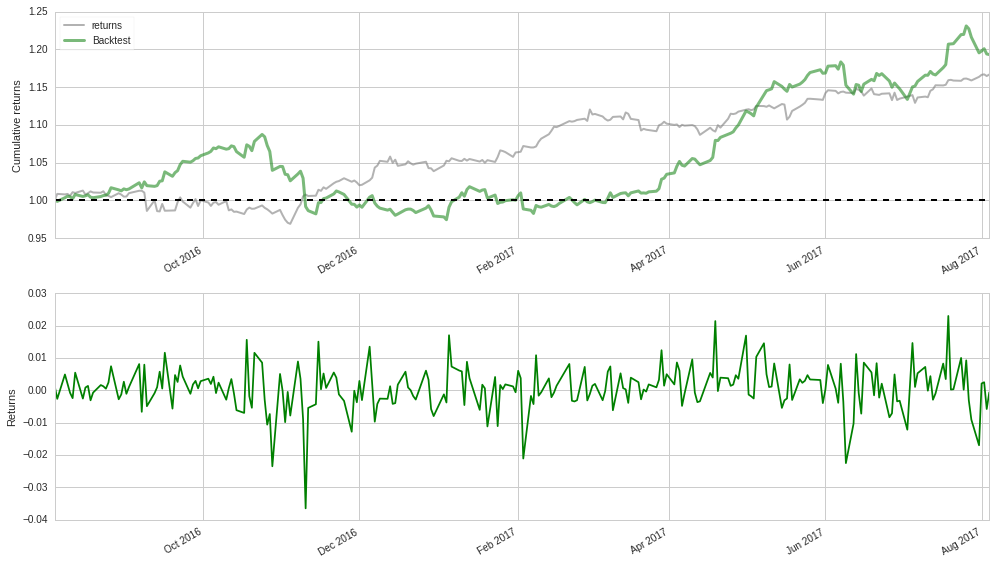

In [174]:
plt.subplot(2,1,1)
pf.plotting.plot_rolling_returns(bt_ret, bm_ret)

plt.subplot(2,1,2)
pf.plotting.plot_returns(bt_ret)
plt.tight_layout();

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,251.00,121.00,130.00
Percent profitable,0.73,0.49,0.95
Winning round_trips,183.00,59.00,124.00
Losing round_trips,68.00,62.00,6.00
Even round_trips,0.00,0.00,0.00


PnL stats,All trades,Short trades,Long trades
Total profit,$1970922.83,$527778.83,$1443144.00
Gross profit,$2137095.06,$690706.90,$1446388.17
Gross loss,$-166172.23,$-162928.06,$-3244.17
Profit factor,$12.86,$4.24,$445.84
Avg. trade net profit,$7852.28,$4361.81,$11101.11
Avg. winning trade,$11678.12,$11706.90,$11664.42
Avg. losing trade,$-2443.71,$-2627.87,$-540.69
Ratio Avg. Win:Avg. Loss,$4.78,$4.45,$21.57
Largest winning trade,$988835.70,$578547.05,$988835.70
Largest losing trade,$-16086.76,$-16086.76,$-2384.78


Duration stats,All trades,Short trades,Long trades
Avg duration,186 days 14:08:36.334661,181 days 13:27:46.115702,191 days 06:28:09.230769
Median duration,190 days 01:00:00,186 days 01:00:00,195 days 13:00:00
Longest duration,364 days 09:29:01,315 days 00:00:00,364 days 09:29:01
Shortest duration,0 days 14:30:59,0 days 14:30:59,0 days 14:30:59


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.07%,0.03%,0.10%
Avg returns winning,0.10%,0.10%,0.10%
Avg returns losing,-0.02%,-0.03%,-0.01%
Median returns all round_trips,0.01%,-0.00%,0.02%
Median returns winning,0.02%,0.01%,0.03%
Median returns losing,-0.01%,-0.02%,-0.00%
Largest winning trade,8.28%,4.85%,8.28%
Largest losing trade,-0.16%,-0.16%,-0.02%


Symbol stats,AMZN-16841,IBM-3766
Avg returns all round_trips,0.10%,0.03%
Avg returns winning,0.10%,0.10%
Avg returns losing,-0.01%,-0.03%
Median returns all round_trips,0.02%,-0.00%
Median returns winning,0.03%,0.01%
Median returns losing,-0.00%,-0.02%
Largest winning trade,8.28%,4.85%
Largest losing trade,-0.02%,-0.16%


Profitability (PnL / PnL total) per name,
AMZN-16841,73.22%
IBM-3766,26.78%


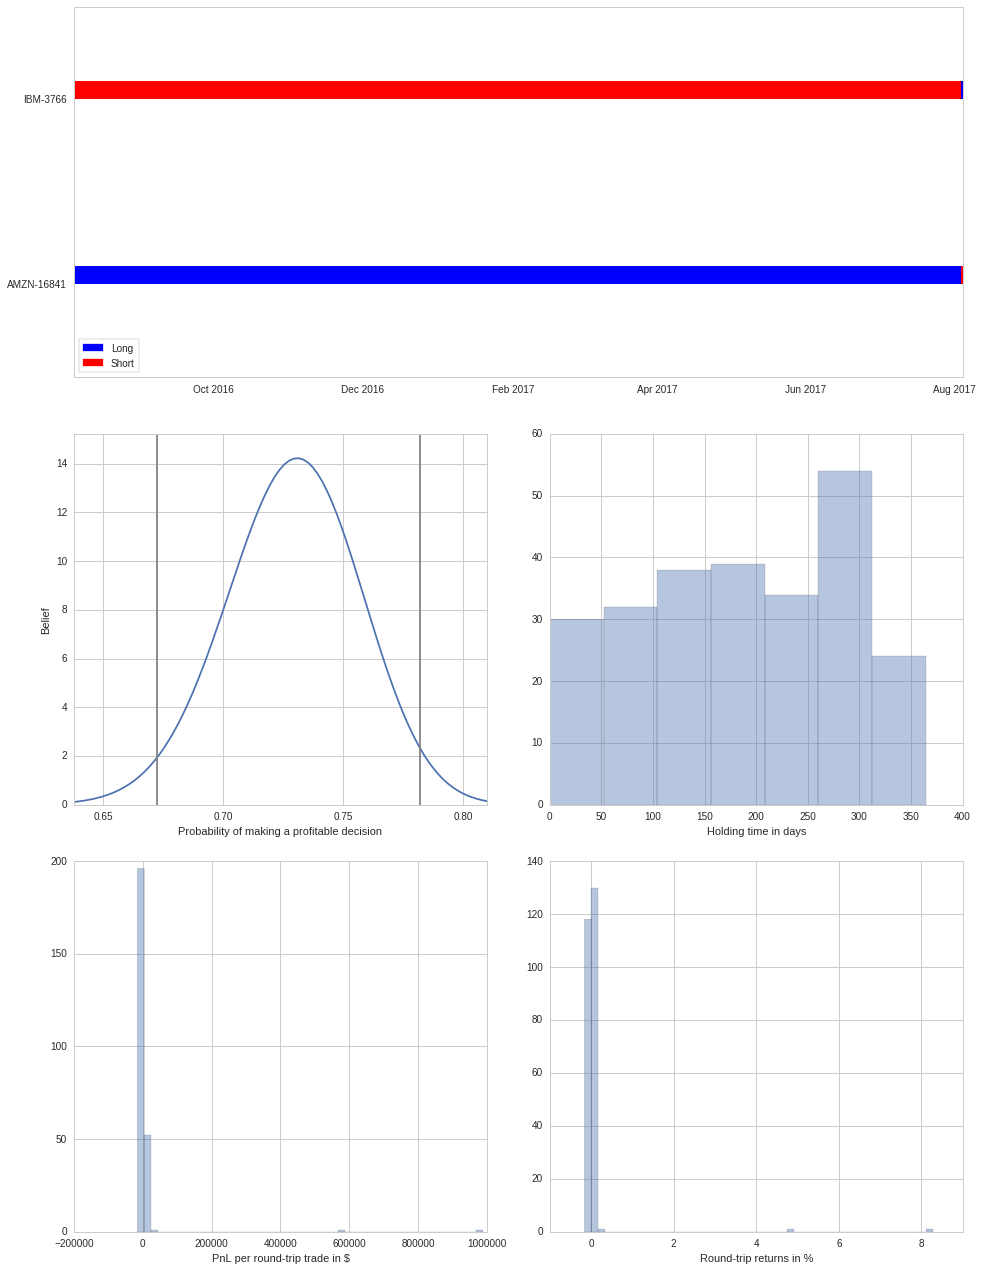

In [176]:
# returns a lot of info
# pf.create_full_tear_sheet(bt_ret, bt_positions, bt_transactions)
pf.create_round_trip_tear_sheet(bt_ret, bt_positions, bt_transactions)

## Futures

### List of all Available Futures (on Quantopian)

Symbol | Future |
--- | --- | 
BD | Big Dow
BO | Soybean Oil
CM | Corn E-Mini
CN | Corn
DJ | DJIA Futures
ET | Ethanol
FF | 30-Day Federal Funds
FI | 5-Year Deliverable Interest Rate Swap Futures
FS | 5-Year Interest Rate Swap Futures
FV | 5-Year T-Note
MB | Municipal Bonds
MS | Soybeans E-Mini
MW | Wheat E-Mini
OA | Oats
RR | Rough Rice
SM | Soybean Meal
SY | Soybeans
TN | 10-Year Deliverable Interest Rate Swap Futures
TS | 10-Year Interest Rate Swap Futures
TU | 2-Year T-Note
TY | 10-Year T-Note
UB | Ultra Tbond
US | 30-Year T-Bond
WC | Wheat
YM | Dow Jones E-mini
VX | VIX Futures
AD | Australian Dollar
AI | Bloomberg Commodity Index Futures
BP | British Pound
CD | Canadian Dollar
EC | Euro FX
ED | Eurodollar
EE | Euro FX E-mini
ES | S&P 500 E-Mini
EU | E-micro EUR/USD Futures
FC | Feeder Cattle
JE | Japanese Yen E-mini
JY | Japanese Yen
LB | Lumber
LC | Live Cattle
LH | Lean Hogs
MD | S&P 400 MidCap Futures
ME | Mexican Peso
MI | S&P 400 MidCap E-Mini
ND | NASDAQ 100 Futures
NK | Nikkei 225 Futures
NQ | NASDAQ 100 E-Mini
NZ | New Zealand Dollar
SF | Swiss Franc
SP | S&P 500 Futures
TB | TBills
GC | Gold
HG | Copper High Grade
SV | Silver
CL | Light Sweet Crude Oil
HO | NY Harbor ULSD Futures
HU | Unleaded Gasoline
NG | Natural Gas
PA | Palladium
PL | Platinum
PB | Pork Bellies
QG | Natural Gas E-mini
QM | Crude Oil E-Mini
XB | RBOB Gasoline Futures
EI | MSCI Emerging Markets Mini
EL | Eurodollar NYSE LIFFE
MG | MSCI EAFE Mini
XG | Gold mini-sized
YS | Silver mini-sized
RM | Russell 1000 Mini
SB | Sugar #11
ER | Russell 2000 Mini

## List of Date/Time Codes

Month | Code |
--- | --- | 
January | F
February | G
March | H
April | J
May | K
June | M
July | N
August | Q
September | U
October | V
November | X
December | Z

Natural Gas
{'root_symbol': u'NG', 'tick_size': 0.001, 'end_date': Timestamp('2019-10-24 00:00:00+0000', tz='UTC'), 'exchange': u'NYMEX', 'auto_close_date': Timestamp('2020-07-27 00:00:00+0000', tz='UTC'), 'expiration_date': Timestamp('2020-07-29 00:00:00+0000', tz='UTC'), 'symbol': u'NGQ20', 'multiplier': 10000.0, 'notice_date': Timestamp('2020-07-30 00:00:00+0000', tz='UTC'), 'first_traded': None, 'asset_name': u'Natural Gas', 'exchange_full': u'NYMEX', 'sid': 1061202008, 'start_date': Timestamp('2014-04-24 00:00:00+0000', tz='UTC'), 'exchange_info': ExchangeInfo(u'NYMEX', u'NYMEX', u'US')}


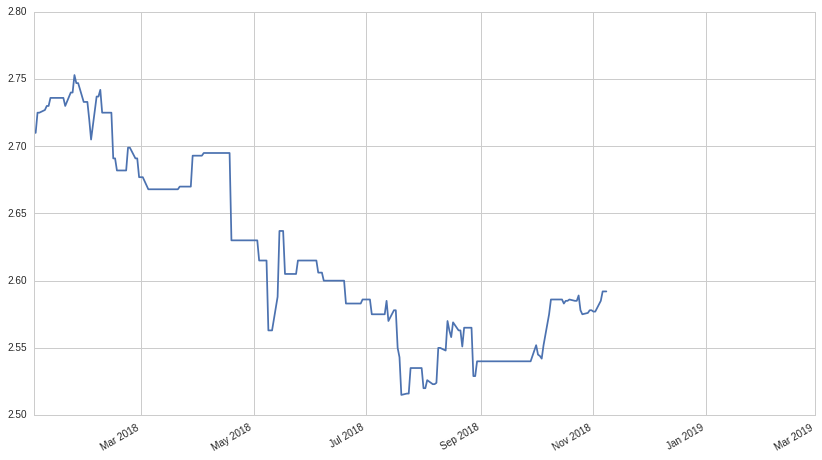

In [16]:
futures = symbols('NGQ20')
print(futures.asset_name)
print(futures.to_dict())
futures_position_value = get_pricing(futures, fields='price', start_date='2018-01-01', end_date='2019-03-01')
futures_position_value.plot();

In [21]:
futures_data = history(
    symbols=futures, 
    fields=['price', 'open_price', 'high', 'low', 'close_price', 'volume', 'contract'],
    frequency='daily',
    start='2018-01-01',
    end='2018-03-01'
)
futures_data.dropna().head()

,price,open_price,high,low,close_price,volume,contract
2018-01-04 00:00:00+00:00,2.725,2.725,2.725,2.725,2.725,2.0,Future(1061202008 [NGQ20])
2018-01-08 00:00:00+00:00,2.727,2.727,2.727,2.727,2.727,2.0,Future(1061202008 [NGQ20])
2018-01-09 00:00:00+00:00,2.730,2.730,2.730,2.730,2.730,2.0,Future(1061202008 [NGQ20])
2018-01-11 00:00:00+00:00,2.736,2.736,2.736,2.736,2.736,6.0,Future(1061202008 [NGQ20])
2018-01-19 00:00:00+00:00,2.730,2.742,2.742,2.730,2.730,15.0,Future(1061202008 [NGQ20])


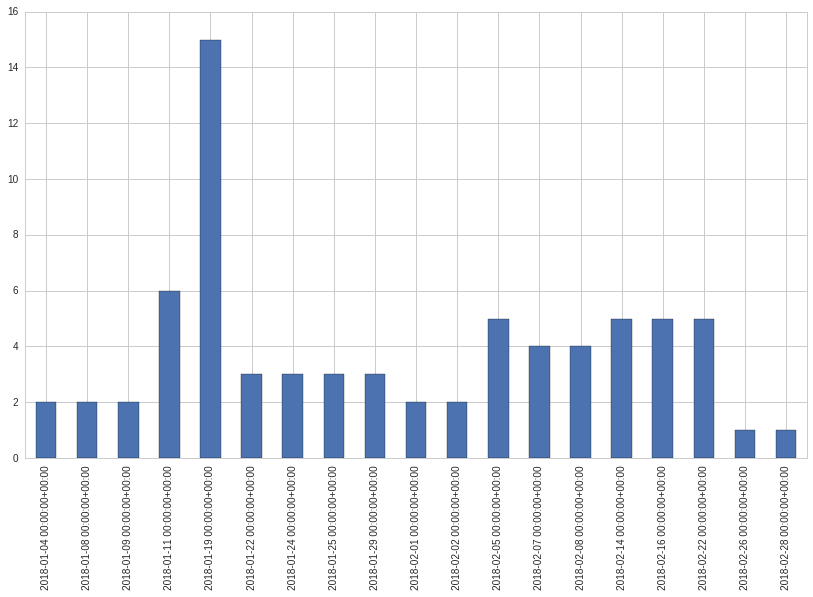

In [23]:
futures_data.dropna()['volume'].plot(kind='bar');

In [24]:
ng_contracts = symbols(['NGF17', 'NGG17', 'NGH17', 'NGJ17', 'NGK17', 'NGM17'])

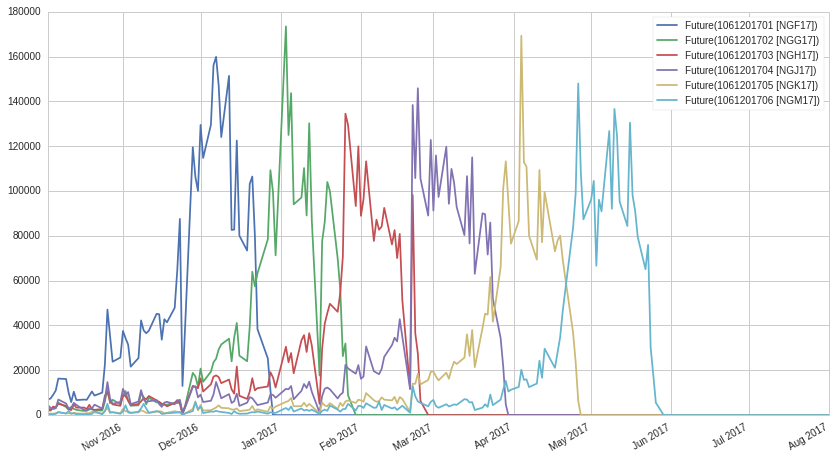

In [28]:
ng_contracts_volume = history(
    symbols=ng_contracts, 
    fields='volume', 
    frequency='daily', 
    start='2016-01-01', 
    end='2017-08-01'
)
ng_contracts_volume['2016-10-01':].plot();

^*Such volume behaviour makes futures hard to trade as liquidity only picks up a few months before expiry before cutting off to 0 at expiry. **Continuous futures** might be easier to trade*

In [32]:
c_futures = continuous_future(root_symbol='NG', roll='volume', adjustment='mul')
c_futures_data = history(
    symbols=c_futures, 
    fields=['contract', 'price', 'volume'], 
    frequency='daily', 
    start='2016-10-01', 
    end='2017-08-01'
)

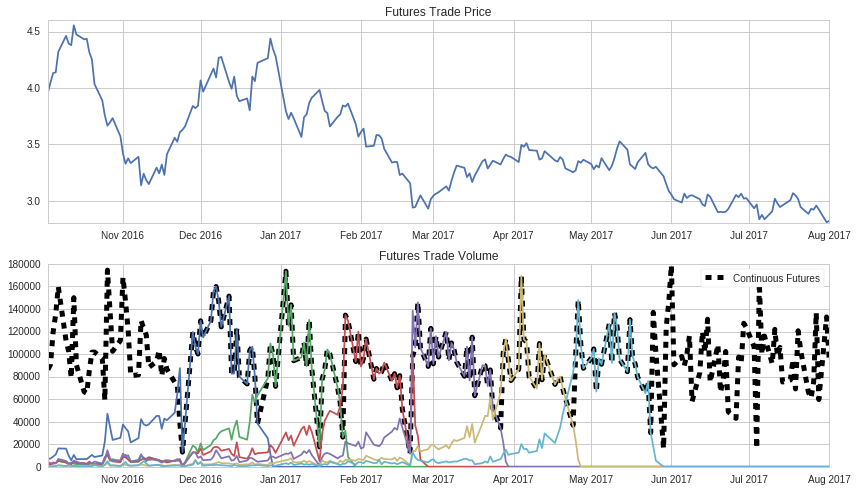

In [42]:
plt.subplot(2,1,1)
plt.plot(c_futures_data['price'])
plt.title('Futures Trade Price')
plt.subplot(2,1,2)
plt.plot(c_futures_data['volume'], label='Continuous Futures', c='black', ls='--', lw='5')
plt.plot(ng_contracts_volume['2016-10-01':])
plt.legend()
plt.title('Futures Trade Volume');

### Continuous Futures
* Continually roll over to the next expiry date, either based on 'calendar' or 'volume' (when max volume cross over). Latter is more common
* When rolling over, differences between prices in the 2 (before/after) contracts can cause gaps. Adjustments can be done to avoid gaps. '**mul**'tiplcative (more common) adjustment uses (before price / after price) multiple